In [298]:
import numpy as np
import matplotlib.pyplot as plt
from TDMA import TDMA   

In [299]:

# --- Load data ---
xc = np.loadtxt('xc.dat')   # grid lines in x (faces) length = nim1
yc = np.loadtxt('yc.dat')   # grid lines in y (faces) length = njm1
u = np.loadtxt('u.dat')     # velocities in MATLAB column-major ordering, length = ni*nj
v = np.loadtxt('v.dat')

# --- Grid bookkeeping (match your original logic) ---
nim1 = len(xc)        # number of grid-lines / faces in x
ni = nim1 + 1         # total nodes (including boundaries) in x-direction
njm1 = len(yc)
nj = njm1 + 1

# reshape velocity arrays (MATLAB column-major => order='F')
u2d = np.reshape(u, (ni, nj), order='F')
v2d = np.reshape(v, (ni, nj), order='F')


In [300]:
# plt.plot(yc)

In [301]:
## Paraameters

rho = 1
k = 1
# cp = k*50
gamma = 0.02
Ua = 1
Vd = 0
Ub = 0
Uc = 1

T_right_boundary_value = 0
T_left_boundary_value = 20
T_top_boundary_value = 0
T_bottom_boundary_value = 0

ep = 1e-5 # Some small value i am adding for division so no inf 

In [302]:
def local_Pe(rho, u_e, u_w, v_n, v_s, del_xe, del_xw, del_xn, del_xs, k_over_cp=1/50):
    factor = rho / k_over_cp  # since k/cp = 1/50

    Pe_e = factor * u_e * del_xe
    Pe_w = factor * u_w * del_xw
    Pe_n = factor * v_n * del_xn
    Pe_s = factor * v_s * del_xs

    Pe_x = (Pe_e + Pe_w) / 2
    Pe_y = (Pe_n + Pe_s) / 2

    Pe_local = np.sqrt(Pe_x**2 + Pe_y**2)

    return Pe_local

In [303]:
grid_shape = [26, 26] # x, y

N = grid_shape[0] * grid_shape[1]
A = np.zeros((N, N))
B = np.zeros(N)



In [304]:
Pe_history = []

for y in range(grid_shape[1]):
    for x in range(grid_shape[0]):
        n = y * grid_shape[0] + x

        del_xe, del_xw, del_xn, del_xs = [None]*4
        a_e = a_w = a_n = a_s = 0.0

        if x == 0: 
            del_xw = xc[0]/2
        if x == grid_shape[0]-1:
            del_xe = xc[-1]/2
        if y == 0: 
            del_xs = yc[0]/2
        if y == grid_shape[1]-1:
            del_xn = yc[-1]/2

        # if x != 0 and x != grid_shape[0]-1 and y != 0 and y != grid_shape[1]-1:
        # if del_xw is None: del_xw = xc[x] - xc[x-1]
        # if del_xe is None: del_xe = xc[x+1] - xc[x]
        # if del_xs is None: del_xs = yc[y] - yc[y - 1]
        # if del_xn is None: del_xn = yc[y + 1] - yc[y]

        if del_xw is None and x > 0:
            del_xw = xc[x] - xc[x-1]
        if del_xe is None and x < grid_shape[0]-1:
            del_xe = xc[x+1] - xc[x]
        if del_xs is None and y > 0:
            del_xs = yc[y] - yc[y-1]
        if del_xn is None and y < grid_shape[1]-1:
            del_xn = yc[y+1] - yc[y]
        
        # Pe = local_Pe(rho, u_e = u2d[y, x], u_w = u2d[y+1, x], v_n = v2d[y, x], v_s = v2d[y, x+1], del_xe = del_xe, del_xw = del_xw, del_xn = del_xn, del_xs = del_xs)
        Pe = local_Pe(
                rho,
                u_e = u2d[y, x+1],
                u_w = u2d[y, x],
                v_n = v2d[y, x],
                v_s = v2d[y+1, x], 
                del_xe = del_xe,
                del_xw = del_xw,
                del_xn = del_xn,
                del_xs = del_xs
            )
        Pe_history.append(Pe)
    
        # Convection Terms
        Fe = rho * u2d[y, x+1] if x < grid_shape[0]-1 else 0.0
        Fs = rho * v2d[y+1, x] if y < grid_shape[1]-1 else 0.0
        Fw = rho * u2d[y, x]   if x > 0 else 0.0
        Fn = rho * v2d[y, x]   if y > 0 else 0.0 

        # Diffusion Terms
        Dn = gamma / (del_xn + ep)
        Ds = gamma / (del_xs + ep)
        De = gamma / (del_xe + ep)
        Dw = gamma / (del_xw + ep) 
        
        if x == 0 and y == 0:
            Fw = rho * Ua
            
        if y == 0 and x == 13:
            Fs = rho * Vd
        
        if y == grid_shape[1]-1 and x == 0:
            Fw = rho * Ub

        if y == grid_shape[1]-1 and x == grid_shape[0]-1:
            Fw = rho * Uc

        if Pe < 2:
                # CD Scheme

                a_n = -Fn/2 + Dn
                a_s =  Fs/2 + Ds
                a_e = -Fe/2 + De
                a_w =  Fw/2 + Dw

                ap = a_n + a_s + a_e + a_w
                
        else:
            # Upwind Scheme

            a_e = De if Fe>0 else De + abs(Fe)
            a_w = Dw + Fw if Fw>0 else Dw
            a_n = Dn if Fn>0 else Dn + abs(Fn)
            a_s = Ds + Fs if Fs>0 else Ds
            
        a_p = a_e + a_w + a_n + a_s + (Fe - Fw + Fn - Fs)

        # Delete kardo later on
        A[n, n] = a_p

        # East neighbor
        if x < grid_shape[0] - 1:
            # Interior nodes: assign normally
            A[n, n+1] = a_e
        else:
            # Rightmost column: Dirichlet BC
            B[n] += a_e * T_right_boundary_value
            a_e = 0.0  # remove from matrix

        # West neighbor
        if x > 0:
            A[n, n-1] = a_w
        else:
            # Bottom-left corner: Dirichlet BC
            if y == 0 and x == 0:
                B[n] += a_w * T_left_boundary_value
                a_w = 0.0  # remove from matrix

        # North neighbor
        if y > 0:
            A[n, n - grid_shape[0]] = a_n
        else:
            # Top row Dirichlet (if needed)
            B[n] += a_n * T_top_boundary_value
            a_n = 0.0

        # South neighbor
        if y < grid_shape[1] - 1:
            A[n, n + grid_shape[0]] = a_s
        else:
            # Bottom row Dirichlet (if needed)
            B[n] += a_s * T_bottom_boundary_value
            a_s = 0.0


In [305]:
A

array([[4.00241202e+03, 1.45600994e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.45600994e+00, 2.00398655e+03, 1.07452993e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.07452993e+00, 2.00332813e+03, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.34839119e+00, 1.07451073e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.07452489e+00, 4.00658516e+00, 1.45601591e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.95602796e+00, 2.45204349e+00]], shape=(676, 676))

In [306]:
phi_vec = np.linalg.solve(A, B)
Ts = phi_vec.reshape(grid_shape[1], grid_shape[0])  # rows=y, cols=x

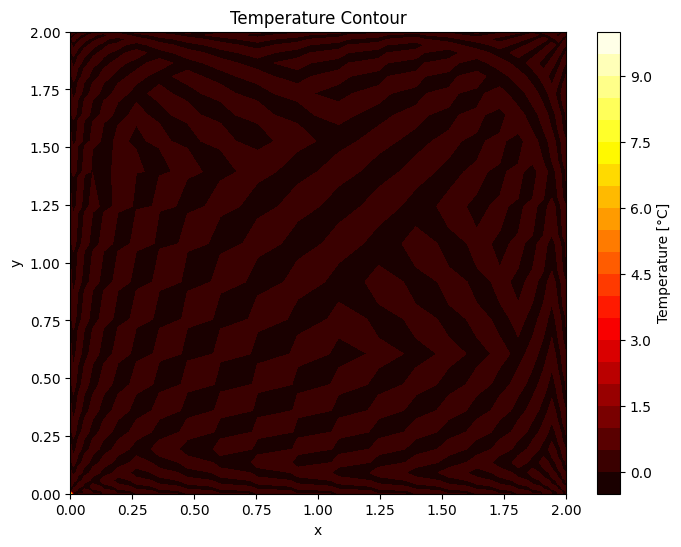

In [307]:
Ts_plot = Ts.T  # now shape (Ny, Nx)

# Create meshgrid for coordinates
X, Y = np.meshgrid(xc, yc)  # xc = x-coordinates, yc = y-coordinates

# Contour plot
plt.figure(figsize=(8,6))
contour = plt.contourf(X, Y, Ts_plot, 20, cmap='hot')  # 20 contour levels
plt.colorbar(contour, label='Temperature [°C]')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Temperature Contour')
plt.show()

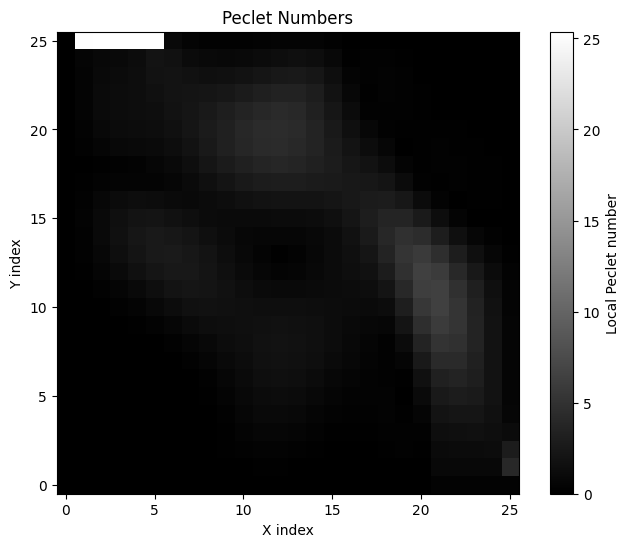

In [308]:
Pe_grid = np.array(Pe_history).reshape(grid_shape[0], grid_shape[1])
plt.figure(figsize=(8,6))
plt.imshow(Pe_grid.T, origin='lower', cmap='gray', interpolation='none')  # transpose for correct orientation
plt.colorbar(label='Local Peclet number')
plt.xlabel('X index')
plt.ylabel('Y index')
plt.title('Peclet Numbers')
plt.show()

In [309]:
Pe_history

[np.float64(3.4315425e-11),
 np.float64(8.780551653905708e-11),
 np.float64(1.1443710139365314e-10),
 np.float64(1.5040579848964552e-10),
 np.float64(1.976103766975323e-10),
 np.float64(2.577464635803464e-10),
 np.float64(3.3173734365909586e-10),
 np.float64(4.1887198484612303e-10),
 np.float64(5.157595833074681e-10),
 np.float64(6.154633802501415e-10),
 np.float64(7.07455731846121e-10),
 np.float64(7.790513747921207e-10),
 np.float64(8.184476955657769e-10),
 np.float64(8.18448694686436e-10),
 np.float64(7.790536226083415e-10),
 np.float64(7.074552324346611e-10),
 np.float64(6.154623818056884e-10),
 np.float64(5.157603316456016e-10),
 np.float64(4.188729814847584e-10),
 np.float64(3.317370950002133e-10),
 np.float64(2.577445458063673e-10),
 np.float64(1.976097858133056e-10),
 np.float64(1.504068548734751e-10),
 np.float64(1.1443855621765212e-10),
 np.float64(8.780560858612988e-11),
 np.float64(4.852903891414509e-11),
 np.float64(1.0697517042908913e-06),
 np.float64(4.487133951750422e-0